In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import features

## Basic EDA

[paper](https://arxiv.org/abs/1909.09347)

In [2]:
""" Given a resolution, the following computes the number of smaples in each chunk. """
fs = 16000 #[Hz]
res = 5 #[Hz]
n = fs//res# [Num. samples in time domain for each chunk] (make next lowest power of 2)
n

3200

In [3]:
# Read data
df = utils.indexFiles(filePath = './data')

# Get ID of the closest mic to the corresponding machine_type
df['closest_mic'] = df['machine_type'].map({'valve': 0, 'pump': 2, 'fan': 4,'slider': 6})

df.head(5)

,filepath,machine_id,machine_type,background_noise,target,closest_mic
0,c:\Users\kalika01\Desktop\MIMII - Sound datase...,0,fan,-6_dB,abnormal,4
1,c:\Users\kalika01\Desktop\MIMII - Sound datase...,0,fan,-6_dB,abnormal,4
2,c:\Users\kalika01\Desktop\MIMII - Sound datase...,0,fan,-6_dB,abnormal,4
3,c:\Users\kalika01\Desktop\MIMII - Sound datase...,0,fan,-6_dB,abnormal,4
4,c:\Users\kalika01\Desktop\MIMII - Sound datase...,0,fan,-6_dB,abnormal,4


### Number of samples and class balance per machine

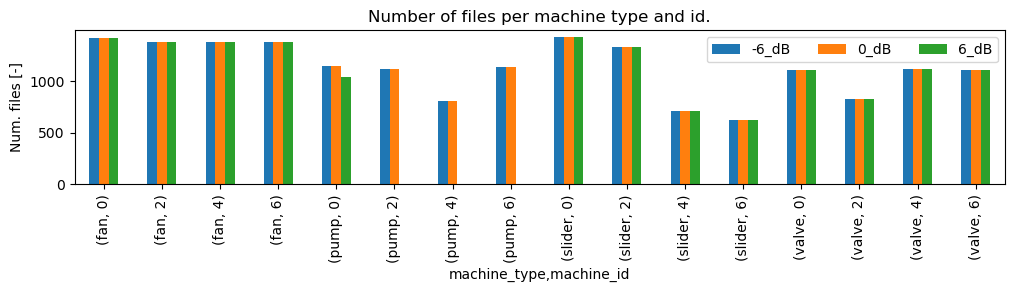

In [4]:
df.groupby(by = ['machine_type', 'machine_id', 'background_noise']).\
nunique()['filepath'].\
unstack().\
plot.bar(
    figsize = (12, 2),
    ylabel = 'Num. files [-]',
    title = 'Number of files per machine type and id.'
).\
legend(loc = 'upper right', ncol = 3);

* 4 machine types (fan, pump, slider, valve)
* 4 machines per type (id 0, 2, 4, 6)
* 3 (well-balanced) background noise levels for each machine type/id (apart from pumps 2, 4, 6 which miss '6dB' background noise levels)

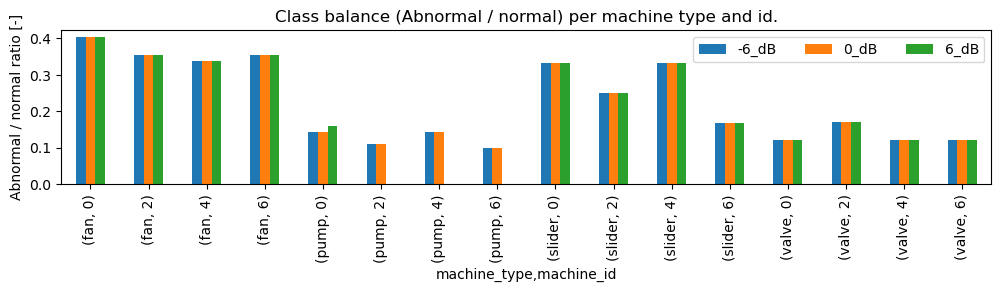

In [5]:
groups = df.groupby(by = ['machine_type', 'machine_id', 'background_noise', 'target']).\
nunique()['filepath'].\
unstack()

groups['class_balance'] = groups['abnormal'] / groups['normal']

groups['class_balance'].\
unstack().\
plot.bar(
    figsize = (12, 2),
    ylabel = 'Abnormal / normal ratio [-]',
    title = 'Class balance (Abnormal / normal) per machine type and id.'
).\
legend(loc = 'upper right', ncol = 3);

Only the fans and some sliders are well-balanced. Nothing extreme though.

### Recordings

Sample waveforms that will be classified:


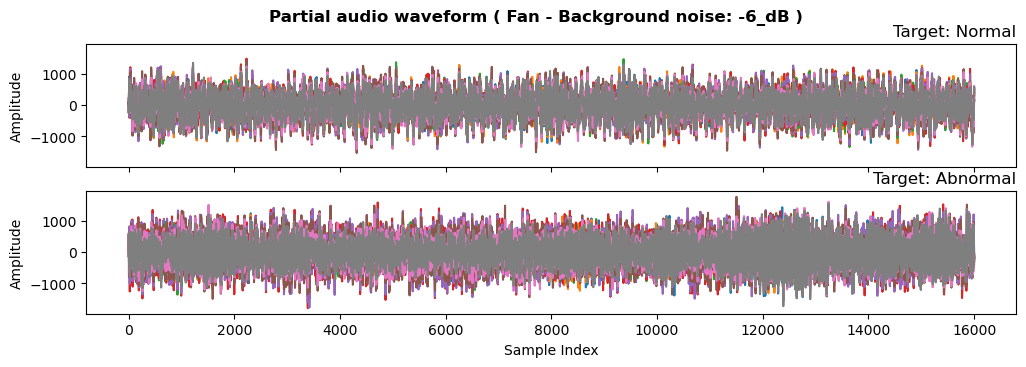

In [6]:

backNoise  = '-6_dB'
machine_id = '0'
numSamples = 16000 # Number of time samples to plot. Entire record is too large to be plotted

for group, data in df.groupby(['machine_type']):

    normal   = data[(data['target'] == 'normal')   & (data['background_noise'] == backNoise)].sample()
    abnormal = data[(data['target'] == 'abnormal') & (data['background_noise'] == backNoise)].sample()

    normalFile   = normal.values[0][0]
    abnormalFile = abnormal.values[0][0]

    normalAudio   = utils.readWav(normalFile)
    abnormalAudio = utils.readWav(abnormalFile)

    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 3.5), sharex=True, sharey=True)
    ax[0].plot(normalAudio[0:numSamples, :])
    ax[0].set_ylabel('Amplitude')
    ax[0].set_title('Target: Normal', loc = 'right')

    ax[1].plot(abnormalAudio[0:numSamples, :])
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Amplitude')
    ax[1].set_title('Target: Abnormal', loc = 'right')

    t = f'Partial audio waveform ( {group[0].title()} - Background noise: {backNoise} )'
    plt.suptitle(t, weight = 'bold');
    
    break

## Feature extractor

*TODO: Write list of features here


In [ ]:
numCores = 6
numFiles = df.shape[0]
pBar     = tqdm(desc = "Extracting features", total = numFiles)

# This will write a (new) .npy file for each datapoint
with features.tqdmJoblib(pBar) as progressBar:
    joblib.Parallel(n_jobs = numCores)(
        joblib.delayed(utils.featureExtractor)(fPath) for fPath in df['filepath'].values
    )

Extracting features: 100%|█████████████████████████████████████████████████████████████████████████████████████| 50895/50895 [4:26:34<00:00,  24.11it/s]

Make the dataset:

Approximately 10% of the extracted features contain between 5% to 20% missing values. All features with more than 5% missing records will be dropped, We will convert the remaining missing values to zeroes. There are a few features (at the tail of the bar plot) with very low variance. Every feature with std lower than 5% of the maximum (=0.2 from the above plot) will be removed:

In [4]:
# Index the files that were just generated
df = utils.indexFiles(filePath = './data', extension = '.npy')

# Make predictors' matrix
X = np.stack([np.load(file) for file in df['filepath'].values], axis = 0)
X = X.reshape(X.shape[0], -1)  # Flatten: Num datapoints x (Num. features * Num. microphones)
X = pd.DataFrame(X)
X = utils.handleMissingValues(X)
X = utils.removeApproxConstant(X)
X = utils.removeCorrelated(X)
X = X.values

# Make target array
y = df['machine_type'].values + '_' + df['target'].values
y = np.array(['normal' if not('abnormal' in target) else target for target in y])

# Make groups for stratification
groups = df['machine_type'] + '_' + df['target']

In [5]:
#X.to_csv('./features.csv')
#np.save('./y.npy', y)
#np.save('./groups.npy', groups)

In [4]:
X = pd.read_csv('./features.csv', index_col = 0).values
y = np.load('./y.npy')
groups = np.load('./groups.npy', allow_pickle = True)

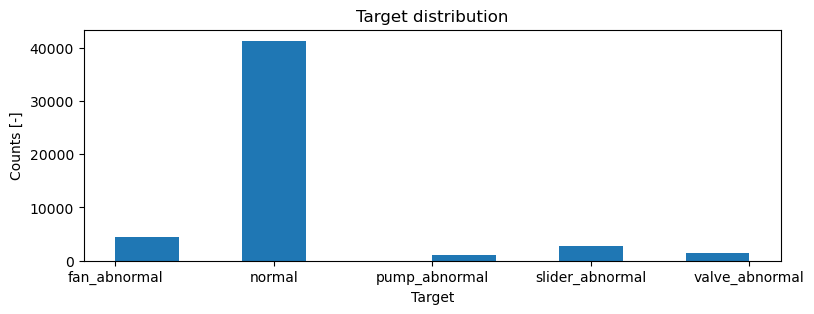

In [5]:
plt.figure(figsize = (9, 3))
plt.hist(y);
plt.title('Target distribution');
plt.ylabel('Counts [-]');
plt.xlabel('Target');

In [6]:
print(f'Predictor matrix shape: {X.shape}. Target matrix shape {y.shape}')

Predictor matrix shape: (50894, 1231). Target matrix shape (50894,)


In [237]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.metrics import roc_auc_score


def classWeights(targets: np.array) -> dict:
    """ Computes the class weights from a 1d-array of classes (targets).
        Inputs:
            targets: 1D Array with the targets of a multi-class classification problem
        Outputs:
            weightDict: Dictionary of classNames: classWeights
    """

    yBin     = pd.get_dummies(targets)  # Binary matrix w/ dimensions:  Num.samples x Num.classes
    counts   = np.bincount(yBin.values.argmax(1)) # Num samples per target
    nSamples = targets.shape[0]
    nClasses = yBin.max()
    weights  = nSamples / (counts * nClasses)
    wDict    = { k:v for k, v in zip(yBin.columns, weights) }
    
    return wDict


def sample(d: dict) -> dict:
    """ Selects a random value from each list field of a dictionary.
        Inputs:
            d: Dict of keys:values (of type list)
        Outputs:
            Dict of of keys: random choice(values)
    """
    return {k: np.random.choice(v) for k, v in d.items()}


def crossValidate(X: np.array, y: np.array, groups: np.array, params: dict, numFolds: int) -> list:
    """ Performs cross validation.
        Inputs:
            X       : Matrix of predictors w/ dimensions: Num. samples x Num. features
            y       : 1D array containing target labels
            groups  : 1D array containing group labels
            params  : Dictionary containing the training parameters of the LightGBM model
            numFolds: Number of folds for cross-validation
        Outputs:
            scores: Array containing the error metric on the validation set
     """

    wDict  = classWeights(y)
    scores = np.nan * np.ones(numFolds)
    cDict  = {k:i for i, (k, _) in enumerate(wDict.items())}
    skf    = StratifiedKFold(
        n_splits = numFolds, shuffle = True, random_state = params['seed']
    )
    
    for i, (trainIdx, testIdx) in enumerate(skf.split(X, groups)):

        Xtrain, ytrain = X[trainIdx, :], y[trainIdx]
        Xtest,  ytest  = X[testIdx, :],  y[testIdx]

        wtrain   = np.vectorize(wDict.get)(ytrain)
        wtest    = np.vectorize(wDict.get)(ytest)

        ytrain   = np.vectorize(cDict.get)(ytrain)
        ytest    = np.vectorize(cDict.get)(ytest)

        trainSet = lgb.Dataset(Xtrain, label = ytrain, weight = wtrain)
        testSet  = lgb.Dataset(Xtest, label = ytest, weight = wtest, reference = trainSet)

        model = lgb.train(params,
            train_set       = trainSet,
            valid_sets      = [testSet], 
            valid_names     = ['val'],
            num_boost_round = params['num_boost_round'],
            callbacks       = [
                lgb.early_stopping(
                    stopping_rounds = params['early_stopping_rounds']
                    )
                ]
            )

        scores[i] = model.best_score['val'][params['metric']]
    
    return scores


In [238]:
SEED      = 321
TEST_SIZE = 0.25
RANDOM_SEARCH_ITERATIONS = 10
NUM_FOLDS = 5

HYPERPARAMETER_SPACE = {
    'num_leaves'      : np.logspace(3, 8, 9, base = 2.0).astype(int),     # Default: 31
    'learning_rate'   : np.logspace(-3, -1/3, 10),                        # Default: 0.1
    'max_depth'       : np.append(-1, np.linspace(3, 16, 7).astype(int)), # Default: -1
    'feature_fraction': np.linspace(0.2, 1.0, 9).round(2),                # Default: 1.0 
    'bagging_fraction': np.linspace(0.2, 1.0, 9).round(2),                # Default: 1.0
    'num_boost_round' : np.logspace(3, 8, 9, base = 2.0).astype(int),     # Default: 100
    }

FIXED_PARAMS = {
    'objective'    : 'multiclass',
    'metric'       : 'multi_logloss',
    'is_unbalance' : True,
    'num_classes'  : 5,
    'num_threads'  : 10,
    'boosting'     :'dart',
    'verbosity'    : -1,
    'seed'         : SEED,
    'early_stopping_rounds': 5,
    }

In [239]:
import engine


# Train/test split
splitter = StratifiedShuffleSplit(n_splits = 1, test_size = TEST_SIZE, random_state = SEED)
trainIdx, testIdx = next(splitter.split(X, groups))
Xtrain, ytrain, groupsTrain = X[trainIdx, :], y[trainIdx], groups[trainIdx]
Xtest, ytest, groupsTest = X[testIdx, :], y[testIdx], groups[testIdx]

def randomSearchCV()

bestScore, bestParams = np.inf, None

for _ in range(RANDOM_SEARCH_ITERATIONS):
    
    # Make a random hyperparameter sample
    params = {**FIXED_PARAMS, **sample(HYPERPARAMETER_SPACE)}

    # Run cross-validation
    scores = crossValidate(Xtrain, ytrain, groupsTrain, params, NUM_FOLDS)
    ffff
    scores = np.random.rand(NUM_FOLDS)

    avgScore = scores.mean()
    if  avgScore < bestScore: 
        bestScore  = avgScore
        bestParams = params

return bestParams, bestScore



NameError: name 'ffff' is not defined

In [236]:
#For all machines togethrer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

model = lgb.LGBMClassifier(is_unbalance=True)
model.fit(Xtrain, ytrain);
y_pred_prob = model.predict_proba(Xtest)
y_pred = model.predict(Xtest)


acc   = accuracy_score(y_pred, ytest)
auroc = roc_auc_score(ytest, y_pred_prob, multi_class = 'ovo', average = 'macro')
print('LightGBM Model accuracy score: {0:0.4f}'.format(acc))
print('LightGBM Model auroc score: {0:0.4f}'.format(auroc))
print(classification_report(ytest, y_pred))
confusion_matrix(ytest, y_pred)

LightGBM Model accuracy score: 0.9853
LightGBM Model auroc score: 0.9986
                 precision    recall  f1-score   support

   fan_abnormal       0.99      0.94      0.96      1106
         normal       0.98      1.00      0.99     10327
  pump_abnormal       0.98      0.76      0.85       264
slider_abnormal       1.00      0.96      0.98       668
 valve_abnormal       1.00      0.96      0.98       359

       accuracy                           0.99     12724
      macro avg       0.99      0.92      0.95     12724
   weighted avg       0.99      0.99      0.98     12724



array([[ 1035,    71,     0,     0,     0],
       [    5, 10317,     4,     1,     0],
       [    5,    59,   200,     0,     0],
       [    0,    28,     0,   640,     0],
       [    0,    14,     0,     0,   345]], dtype=int64)

TODO: 
* Continue the pipeline from the book

check these for another pipeline
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52
* https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

check librosa for feature extraction
* https://librosa.org/doc/main/_modules/librosa/feature/spectral.html#rms